In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import networkx as nx
from pandas.io.json import json_normalize
from functools import reduce
from scipy import sparse

%reload_ext lab_black

In [2]:
def col_json_to_dict(df, cols):
    "Transform the json values inside a column into list of dictionaries"
    transformed_df = df
    for col in cols:
        transformed_df = transformed_df.assign(**{col: df[col].apply(json.loads)})
    return transformed_df

In [3]:
def col_dict_to_set(df, col, key):
    "Create a set from the values of the dictionaries give a key"
    get_set = lambda dict_list: set([dict_.get(key) for dict_ in dict_list])
    return df.assign(**{col: df[col].apply(get_set)})

In [4]:
def col_filter_dict_with_vals(df, col, field, values):
    "Filter dictionaries with specific values from a column with lists of dictionaries"
    filter_dicts = lambda dict_list: [
        dict_ for dict_ in dict_list if dict_.get(field) in values
    ]
    return df.assign(**{col: df[col].apply(filter_dicts)})

In [5]:
credits_df = pd.read_csv("./data/tmdb_5000_credits.csv", sep=",", quotechar='"')
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies_df = pd.read_csv("./data/tmdb_5000_movies.csv", sep=",", quotechar='"').rename(
    {"id": "movie_id"}, axis=1
)
movies_df.head()

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
credits_df_cp = credits_df.copy()
movies_df_cp = movies_df.copy()

## Clean movies_df_cp

In [8]:
# movies with empty genre field
len(movies_df_cp[movies_df_cp.astype(str)["genres"] == "[]"])

28

In [9]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_companies"] == "[]"])

351

In [10]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_countries"] == "[]"])

174

In [11]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["spoken_languages"] == "[]"])

86

## Process movies df

In [12]:
pr_movies_df = movies_df_cp
len(pr_movies_df)

4803

In [13]:
pr_movies_df.head()

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [14]:
# Transform json to list of dictionaries within cols
movies_df_json_cols = [
    "genres",
    "production_companies",
    "keywords",
    "production_countries",
    "spoken_languages",
]
cols_to_drop = ["homepage", "overview", "tagline", "original_title"]
key = "name"
movie_id_col = "movie_id"

pr_movies_df = col_json_to_dict(pr_movies_df, movies_df_json_cols)
for col in movies_df_json_cols:
    pr_movies_df = col_dict_to_set(pr_movies_df, col, key)
pr_movies_df = pr_movies_df.drop(columns=cols_to_drop)
pr_movies_df.head()

,budget,genres,movie_id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,237000000,"{Action, Adventure, Science Fiction, Fantasy}",19995,"{battle, anti war, alien, mind and soul, space...",en,150.437577,"{Lightstorm Entertainment, Ingenious Film Part...","{United Kingdom, United States of America}",2009-12-10,2787965087,162.0,"{English, Español}",Released,Avatar,7.2,11800
1,300000000,"{Action, Adventure, Fantasy}",285,"{afterlife, traitor, ship, drug abuse, ocean, ...",en,139.082615,"{Jerry Bruckheimer Films, Second Mate Producti...",{United States of America},2007-05-19,961000000,169.0,{English},Released,Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"{Action, Adventure, Crime}",206647,"{secret agent, united kingdom, british secret ...",en,107.376788,"{B24, Danjaq, Columbia Pictures}","{United Kingdom, United States of America}",2015-10-26,880674609,148.0,"{Français, English, Español, Deutsch, Italiano}",Released,Spectre,6.3,4466
3,250000000,"{Action, Drama, Crime, Thriller}",49026,"{catwoman, villainess, destruction, secret ide...",en,112.312950,"{Syncopy, Legendary Pictures, Warner Bros., DC...",{United States of America},2012-07-16,1084939099,165.0,{English},Released,The Dark Knight Rises,7.6,9106
4,260000000,"{Action, Adventure, Science Fiction}",49529,"{martian, 19th century, medallion, sword and p...",en,43.926995,{Walt Disney Pictures},{United States of America},2012-03-07,284139100,132.0,{English},Released,John Carter,6.1,2124


## Process credits df

In [15]:
pr_credits_df = credits_df_cp
credits_df_json_cols = ["cast", "crew"]
key = "name"
pr_credits_df = col_json_to_dict(pr_credits_df, credits_df_json_cols)
pr_credits_df = pr_credits_df.assign(actors=pr_credits_df[credits_df_json_cols[0]])
for col in credits_df_json_cols:
    if col != "crew":
        pr_credits_df = col_dict_to_set(pr_credits_df, col, key)
crew_col = "crew"
job_field = "job"
values = ["Director"]
# Filter dictionaries with Director as job
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, crew_col, job_field, values
).rename({crew_col: values[0]})
pr_credits_df = col_dict_to_set(pr_credits_df, crew_col, key)
# Get actors col
# Only select main actors to reduce the size of the dataset
actors_col = "actors"
order_field = "order"
# Select the number of important actors
values = [0, 1]
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, actors_col, order_field, values
).rename({crew_col: values[0]})

get_value = lambda dict_: dict_.get(key)

pr_credits_df = pr_credits_df.explode(actors_col)
pr_credits_df = pr_credits_df[pr_credits_df[actors_col].notna()]
actors_series = pr_credits_df[actors_col]
pr_credits_df = pr_credits_df.assign(
    **{actors_col: pr_credits_df[actors_col].apply(get_value)}
)
# Remove actor from cast
actor_cast_col = "actor_cast"
pr_credits_df = pr_credits_df.reset_index(drop=True)
remove_from_cast = lambda row: row[credits_df_json_cols[0]] - set({row[actors_col]})
pr_credits_df = pr_credits_df.assign(
    **{credits_df_json_cols[0]: pr_credits_df.apply(remove_from_cast, axis=1)}
).drop(columns="title")
pr_credits_df.head()

,movie_id,cast,crew,actors
0,19995,"{Zoe Saldana, Jamie Harrison, Mike Bodnar, Tay...",{James Cameron},Sam Worthington
1,19995,"{Jamie Harrison, Mike Bodnar, Taylor Kibby, Ka...",{James Cameron},Zoe Saldana
2,285,"{Reggie Lee, Keith Richards, Ghassan Massoud, ...",{Gore Verbinski},Johnny Depp
3,285,"{Reggie Lee, Keith Richards, Ghassan Massoud, ...",{Gore Verbinski},Orlando Bloom
4,206647,"{Detlef Bothe, Pip Carter, Nari Blair-Mangat, ...",{Sam Mendes},Daniel Craig


In [16]:
actor_cols = ["name", "gender", "order"]
actors_df = json_normalize(actors_series)[actor_cols]
actors_df = (
    actors_df.rename(columns={actor_cols[0]: actors_col})
    .groupby(actors_col)
    .aggregate({actor_cols[1]: max, actor_cols[2]: list})
    .reset_index()
    .reset_index()
    .rename(columns={"index": "actor_id"})
)
actors_df

,actor_id,actors,gender,order
0,0,"""Weird Al"" Yankovic",0,[0]
1,1,50 Cent,2,[0]
2,2,A.J. Buckley,2,[1]
3,3,A.J. Cook,1,[1]
4,4,AJ Michalka,1,[0]
...,...,...,...,...
3765,3765,Zoe Sloane,0,[0]
3766,3766,Zooey Deschanel,1,"[1, 1, 1, 1, 0, 1]"
3767,3767,Zoë Kravitz,1,[1]
3768,3768,Zuleikha Robinson,1,[1]


In [17]:
actors_credits_df = pr_credits_df.merge(
    actors_df, right_on=actors_col, left_on=actors_col, how="inner"
)
actors_credits_df.head(20)

,movie_id,cast,crew,actors,actor_id,gender,order
0,19995,"{Zoe Saldana, Jamie Harrison, Mike Bodnar, Tay...",{James Cameron},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
1,534,"{Chris Ashworth, Bryce Dallas Howard, Anton Ye...",{McG},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
2,57165,"{Liam Neeson, Bill Nighy, Lily James, Kathryn ...",{Jonathan Liebesman},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
3,18823,"{David Kennedy, Polly Walker, Luke Evans, Alex...",{Louis Leterrier},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
4,49527,"{Liz Holtan, J. Bernard Calloway, Frank Anello...",{Asger Leth},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
5,144336,"{Parisa Johnston, Morgan Alexandria, Maurice C...",{David Ayer},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]"
6,19995,"{Jamie Harrison, Mike Bodnar, Taylor Kibby, Ka...",{James Cameron},Zoe Saldana,3764,1,"[1, 1, 0, 1, 1, 1, 1, 1, 1]"
7,118340,"{Jennifer Moylan-Taylor, Keeley Forsyth, Ophel...",{James Gunn},Zoe Saldana,3764,1,"[1, 1, 0, 1, 1, 1, 1, 1, 1]"
8,62835,"{Cliff Curtis, Beto Benitez, Amandla Stenberg,...",{Olivier Megaton},Zoe Saldana,3764,1,"[1, 1, 0, 1, 1, 1, 1, 1, 1]"
9,34813,"{Ramiro 'Ramir' Delgado Ruiz, Robert Slavonia,...",{Sylvain White},Zoe Saldana,3764,1,"[1, 1, 0, 1, 1, 1, 1, 1, 1]"


In [18]:
movie_id_col = "movie_id"
new_movie_id_col = "new_movie_id"
actors_movies_credits_df = actors_credits_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
)
# Set new movie ids
unique_movies_df = (
    pr_movies_df[movie_id_col]
    .to_frame()
    .drop_duplicates()
    .reset_index()
    .rename(columns={"index": new_movie_id_col})
)
actors_movies_credits_df = (
    actors_movies_credits_df.merge(
        unique_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
    )
    .drop(columns=movie_id_col)
    .rename(columns={new_movie_id_col: movie_id_col})
)

actors_movies_credits_df.head()

,cast,crew,actors,actor_id,gender,order,budget,genres,keywords,original_language,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,movie_id
0,"{Zoe Saldana, Jamie Harrison, Mike Bodnar, Tay...",{James Cameron},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]",237000000,"{Action, Adventure, Science Fiction, Fantasy}","{battle, anti war, alien, mind and soul, space...",en,...,"{United Kingdom, United States of America}",2009-12-10,2787965087,162.0,"{English, Español}",Released,Avatar,7.2,11800,0
1,"{Jamie Harrison, Mike Bodnar, Taylor Kibby, Ka...",{James Cameron},Zoe Saldana,3764,1,"[1, 1, 0, 1, 1, 1, 1, 1, 1]",237000000,"{Action, Adventure, Science Fiction, Fantasy}","{battle, anti war, alien, mind and soul, space...",en,...,"{United Kingdom, United States of America}",2009-12-10,2787965087,162.0,"{English, Español}",Released,Avatar,7.2,11800,0
2,"{Chris Ashworth, Bryce Dallas Howard, Anton Ye...",{McG},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]",200000000,"{Action, Science Fiction, Thriller}","{cyborg, saving the world, post-apocalyptic, d...",en,...,"{United Kingdom, Italy, Germany, United States...",2009-05-20,371353001,115.0,"{English, Italiano}",Released,Terminator Salvation,5.9,2463,43
3,"{Chris Ashworth, Bryce Dallas Howard, Anton Ye...",{McG},Christian Bale,620,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...",200000000,"{Action, Science Fiction, Thriller}","{cyborg, saving the world, post-apocalyptic, d...",en,...,"{United Kingdom, Italy, Germany, United States...",2009-05-20,371353001,115.0,"{English, Italiano}",Released,Terminator Salvation,5.9,2463,43
4,"{Liam Neeson, Bill Nighy, Lily James, Kathryn ...",{Jonathan Liebesman},Sam Worthington,3169,2,"[0, 1, 0, 0, 0, 1]",150000000,{Adventure},"{based on greek myth, zeus, 3d, perseus, hades...",en,...,"{Spain, United States of America}",2012-03-27,301000000,99.0,{English},Released,Wrath of the Titans,5.5,1431,132


In [19]:
aux_movies_df = unique_movies_df.merge(
    pr_movies_df[["movie_id", "title"]].drop_duplicates(),
    right_on="movie_id",
    left_on="movie_id",
)
aux_movies_df.head()

,new_movie_id,movie_id,title
0,0,19995,Avatar
1,1,285,Pirates of the Caribbean: At World's End
2,2,206647,Spectre
3,3,49026,The Dark Knight Rises
4,4,49529,John Carter


In [20]:
actors_movies_credits_df.columns

Index(['cast', 'crew', 'actors', 'actor_id', 'gender', 'order', 'budget',
       'genres', 'keywords', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title',
       'vote_average', 'vote_count', 'movie_id'],
      dtype='object')

In [21]:
len(actors_movies_credits_df)

9296

In [22]:
get_union = lambda s: reduce(set.union, s)
actor_id_col = "actor_id"
actors_agg_df = (
    actors_movies_credits_df.groupby(actors_col)
    .aggregate(
        {
            "movie_id": set,
            "cast": get_union,
            "crew": get_union,
            "actor_id": max,
            "gender": max,
            "budget": "mean",
            "genres": get_union,
            "keywords": get_union,
            "original_language": set,
            "popularity": "mean",
            "production_companies": get_union,
            "production_countries": get_union,
            "release_date": list,
            "revenue": "mean",
            "runtime": sum,
            "spoken_languages": get_union,
            "status": list,
            "title": set,
            "vote_average": "mean",
            "vote_count": "mean",
        }
    )
    .set_index(actor_id_col)
)
actors_agg_df.head()

,movie_id,cast,crew,gender,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
actor_id,,,,,,,,,,,,,,,,,,,
0,{3619},"{David Bowe, Trinidad Silva, Anthony Geary, Mi...",{Jay Levey},0,5000000.0,{Comedy},"{indiana jones spoof scene, satire, tv star, g...",{en},4.070044,"{Cinecorp, Orion Pictures}",{United States of America},[1989-07-21],0.0,97.0,{English},[Released],{UHF},6.7,89.0
1,{1233},"{Sullivan Walker, Terrence Howard, Joseph Pier...",{Jim Sheridan},2,40000000.0,{Drama},"{career, musical, attempted murder, drug, rapp...",{en},12.885985,"{Paramount Pictures, MTV Films, Cent Productio...",{United States of America},[2005-11-09],46442528.0,117.0,{English},[Released],{Get Rich or Die Tryin'},6.3,186.0
2,{4034},"{Ron Roggé, Vanessa Evigan, Piper Mackenzie Ha...",{John Murlowski},2,0.0,"{Comedy, Family}",{},{en},0.630226,{},{United States of America},[2010-12-01],0.0,89.0,{English},[Released],{Christmas Mail},5.0,15.0
3,{1789},"{Alejandro Rae, Shaun Sipos, Ali Larter, Micha...",{David R. Ellis},1,26000000.0,"{Mystery, Horror}","{hospital, premonition, ambulance}",{en},37.355826,"{New Line Cinema, Zide-Perry Productions}",{United States of America},[2003-01-31],90426405.0,90.0,{English},[Released],{Final Destination 2},5.9,1023.0
4,{4203},"{Kevin Pollak, James Denton, Jamie Grace, Shaw...",{Brad J. Silverman},1,0.0,"{Drama, Music}",{christian},{en},2.160586,"{Birchwood Pictures, Coram Deo Studios}",{United States of America},[2013-10-04],0.0,102.0,{English},[Released],{Grace Unplugged},6.0,24.0


## Build graph

In [23]:
nodes_df = actors_agg_df[["cast", "crew", "production_companies", "genres", "movie_id"]]
nodes_df.head()

,cast,crew,production_companies,genres,movie_id
actor_id,,,,,
0,"{David Bowe, Trinidad Silva, Anthony Geary, Mi...",{Jay Levey},"{Cinecorp, Orion Pictures}",{Comedy},{3619}
1,"{Sullivan Walker, Terrence Howard, Joseph Pier...",{Jim Sheridan},"{Paramount Pictures, MTV Films, Cent Productio...",{Drama},{1233}
2,"{Ron Roggé, Vanessa Evigan, Piper Mackenzie Ha...",{John Murlowski},{},"{Comedy, Family}",{4034}
3,"{Alejandro Rae, Shaun Sipos, Ali Larter, Micha...",{David R. Ellis},"{New Line Cinema, Zide-Perry Productions}","{Mystery, Horror}",{1789}
4,"{Kevin Pollak, James Denton, Jamie Grace, Shaw...",{Brad J. Silverman},"{Birchwood Pictures, Coram Deo Studios}","{Drama, Music}",{4203}


In [24]:
dict_actor_id = dict(zip(actors_df[actors_col], actors_df[actor_id_col]))
dict_id_actor = dict(zip(actors_df[actor_id_col], actors_df[actors_col]))

## Get cast intersecctions length mat

In [25]:
import timeit


def get_intersections_length_adj_mat(col):
    "Get the intersecction length of the set of each entry with the set of every other entry in the column"
    start = timeit.default_timer()
    adj = np.zeros((col.shape[0], col.shape[0]))
    for (i, set_row) in enumerate(col):
        for (j, set_col) in enumerate(col):
            try:
                adj[i, j] = len(set_row.intersection(set_col))
            except AttributeError:
                adj[i, j] = 0
    stop = timeit.default_timer()
    print("Time: ", stop - start)
    return adj

In [26]:
def get_unions_length_adj_mat(col):
    "Get the unions length of the set of each entry with the set of every other entry in the column"
    start = timeit.default_timer()
    adj = np.zeros((col.shape[0], col.shape[0]))
    for (i, set_row) in enumerate(col):
        for (j, set_col) in enumerate(col):
            try:
                adj[i, j] = len(set_row.union(set_col))
            except AttributeError:
                adj[i, j] = 0
    stop = timeit.default_timer()
    print("Time: ", stop - start)
    return adj

## Get cast intersections

In [27]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_raw = get_intersections_length_adj_mat(cast_col)
cast_adj_diag = np.diag(np.diag(cast_adj_raw))
cast_adj = cast_adj_raw - cast_adj_diag

Time:  15.0813199


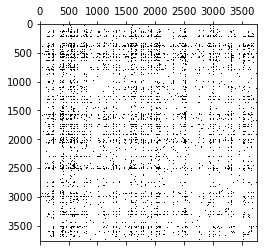

In [28]:
plt.spy(cast_adj)

In [29]:
np.save("cast_adj", cast_adj)

## Load cast adjacency matrix

In [30]:
cast_adj = np.load("cast_adj.npy")

In [31]:
cast_adj.shape

(3770, 3770)

In [32]:
node_degree = cast_adj.sum(axis=0)

In [33]:
most_connected_actors_id = np.argsort(-node_degree)[:20]
most_connected_actors = [dict_id_actor.get(id_) for id_ in most_connected_actors_id]
actors_df[actors_df[actor_id_col].isin(most_connected_actors_id)]
print(most_connected_actors)

['Matt Damon', 'Bruce Willis', 'Robert De Niro', 'Denzel Washington', 'Mark Wahlberg', 'Johnny Depp', 'Ben Stiller', 'Tom Hanks', 'Brad Pitt', 'George Clooney', 'Tom Cruise', 'Nicolas Cage', 'Christian Bale', 'Ben Affleck', 'Leonardo DiCaprio', 'Owen Wilson', 'Harrison Ford', 'Russell Crowe', 'John Travolta', 'Will Smith']


## Get cast unions length mat

In [34]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_union_raw = get_unions_length_adj_mat(cast_col)
cast_adj_union_diag = np.diag(np.diag(cast_adj_union_raw))
cast_adj_union = cast_adj_union_raw - cast_adj_union_diag

Time:  58.0809291


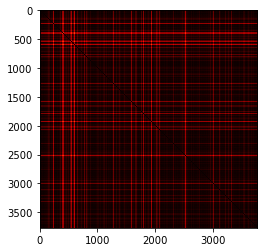

In [35]:
plt.imshow(cast_adj_union, cmap="hot", interpolation="none")

In [36]:
np.save("cast_adj_union", cast_adj_union)

## Get movies intersections length mat

In [37]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_raw = get_intersections_length_adj_mat(movie_col)
movie_adj_diag = np.diag(np.diag(movie_adj_raw))
movie_adj = movie_adj_raw - movie_adj_diag

Time:  6.941259100000011


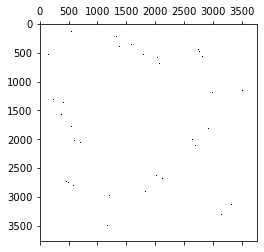

In [38]:
plt.spy(movie_adj)

In [39]:
np.save("movie_adj", movie_adj)

## Get movies union length mat

In [40]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_union_raw = get_unions_length_adj_mat(movie_col)
movie_adj_union_diag = np.diag(np.diag(movie_adj_union_raw))
movie_adj_union = movie_adj_union_raw - movie_adj_union_diag

Time:  8.787211799999994


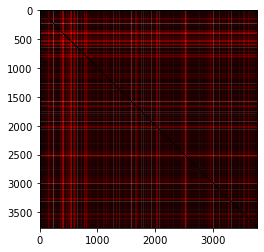

In [41]:
plt.imshow(movie_adj_union, cmap="hot", interpolation="none")

In [42]:
np.save("movie_adj_union", movie_adj_union)

## Get directors intersections lenght mat

In [43]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_raw = get_intersections_length_adj_mat(crew_col)
crew_adj_diag = np.diag(np.diag(crew_adj_raw))
crew_adj = crew_adj_raw - crew_adj_diag

Time:  7.231373699999992


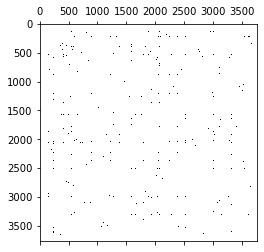

In [44]:
plt.spy(crew_adj)

In [45]:
np.save("crew_adj", crew_adj)

## Get directors union length mat

In [46]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_union_raw = get_unions_length_adj_mat(crew_col)
crew_adj_union_diag = np.diag(np.diag(crew_adj_union_raw))
crew_adj_union = crew_adj_union_raw - crew_adj_union_diag

Time:  9.1199127


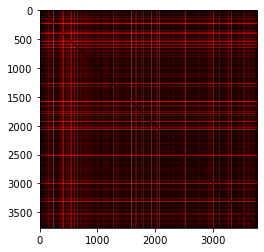

In [47]:
plt.imshow(crew_adj_union, cmap="hot", interpolation="none")

In [48]:
np.save("crew_adj_union", crew_adj_union)

## Get production companies intersections length mat

In [49]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_raw = get_intersections_length_adj_mat(prod_comp_col)
prod_comp_adj_diag = np.diag(np.diag(prod_comp_adj_raw))
prod_comp_adj = prod_comp_adj_raw - prod_comp_adj_diag

Time:  8.685163099999983


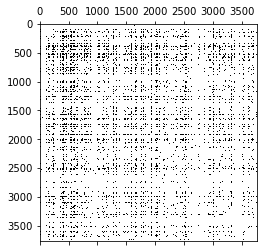

In [50]:
plt.spy(prod_comp_adj)

In [51]:
np.save("prod_comp_adj", prod_comp_adj)

## Get production companies unions length mat

In [52]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_union_raw = get_unions_length_adj_mat(prod_comp_col)
prod_comp_adj_union_diag = np.diag(np.diag(prod_comp_adj_union_raw))
prod_comp_adj_union = prod_comp_adj_union_raw - prod_comp_adj_union_diag

Time:  12.489993099999992


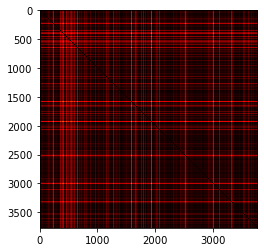

In [53]:
plt.imshow(prod_comp_adj_union, cmap="hot", interpolation="none")

In [54]:
np.save("prod_comp_adj_union", prod_comp_adj_union)

## Get genres intersections length mat

In [55]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_raw = get_intersections_length_adj_mat(genres_col)
genres_adj_diag = np.diag(np.diag(genres_adj_raw))
genres_adj = genres_adj_raw - genres_adj_diag

Time:  8.127426600000007


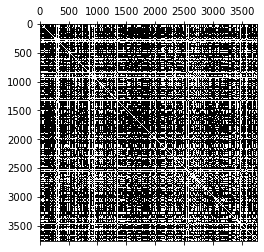

In [56]:
plt.spy(genres_adj)

In [57]:
np.save("genres_adj", genres_adj)

## Get genres unions length mat

In [58]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_union_raw = get_unions_length_adj_mat(genres_col)
genres_adj_union_diag = np.diag(np.diag(genres_adj_union_raw))
genres_adj_union = genres_adj_union_raw - genres_adj_union_diag

Time:  11.236002299999996


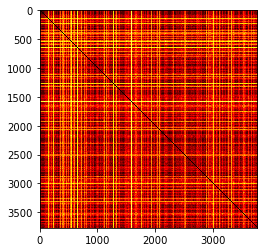

In [59]:
plt.imshow(genres_adj_union, cmap="hot", interpolation="none")

In [60]:
np.save("genres_adj_union", genres_adj_union)

## Aggregated adjacency matrix

In [61]:
agg_adj = np.divide(
    (
        0.3 * cast_adj
        + 0.3 * movie_adj
        + 0.2 * crew_adj
        + 0.1 * genres_adj
        + 0.1 * prod_comp_adj
    ),
    (
        0.3 * cast_adj_union
        + 0.3 * movie_adj_union
        + 0.2 * crew_adj_union
        + 0.1 * genres_adj_union
        + 0.1 * prod_comp_adj_union
    ),
)
agg_adj = np.where(np.isnan(agg_adj), 0, agg_adj)
np.sum(agg_adj)

C:\Users\AndresMontero\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


77236.65386911613

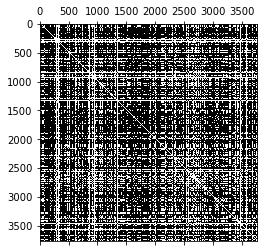

In [62]:
plt.spy(agg_adj)

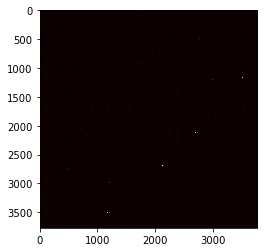

In [63]:
plt.imshow(agg_adj, cmap="hot", interpolation="none")

In [64]:
np.min(agg_adj)

0.0

In [65]:
np.max(agg_adj)

0.9850374064837905

In [66]:
np.save("agg_adj", agg_adj)

## Sparsify graph

In [67]:
agg_adj = np.load("agg_adj.npy")

In [68]:
def sparsify_adj(adj, epsilon):
    return np.where(adj <= epsilon, 0, adj)

In [69]:
percentile = 70
eps = np.percentile(agg_adj, 70)
print(eps)

0.007038783699837348


In [70]:
sparse_agg_adj = sparsify_adj(agg_adj, eps)

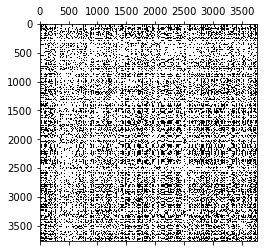

In [71]:
plt.spy(sparse_agg_adj)

In [72]:
actors_graph = nx.from_numpy_matrix(sparse_agg_adj)

In [73]:
csr_sparse_agg_adj = sparse.csr_matrix(sparse_agg_adj)

In [74]:
np.save("sparse_agg_adj_actors", sparse_agg_adj)

## Tests

### Test consistency of data

In [75]:
dict_actor_id.get("Sam Worthington")

3169

In [76]:
actors_df[actors_df["actors"] == "Adriana Barraza"]

,actor_id,actors,gender,order
45,45,Adriana Barraza,1,[0]


In [77]:
dict_actor_id.get("Andreas Berg")

In [78]:
actors_df[actors_df["actor_id"] == 1000]

,actor_id,actors,gender,order
1000,1000,Elden Henson,2,"[1, 1]"


In [79]:
nodes_df.loc[0, "cast"]

{'Anthony Geary',
 'Billy Barty',
 'David Bowe',
 'Emo Philips',
 'Fran Drescher',
 'Kevin McCarthy',
 'Michael Richards',
 'Trinidad Silva',
 'Victoria Jackson'}

In [80]:
# Test number of actors
len(np.unique(actors_agg_df.index.values))

3770

In [81]:
actors_agg_df

,movie_id,cast,crew,gender,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
actor_id,,,,,,,,,,,,,,,,,,,
0,{3619},"{David Bowe, Trinidad Silva, Anthony Geary, Mi...",{Jay Levey},0,5.000000e+06,{Comedy},"{indiana jones spoof scene, satire, tv star, g...",{en},4.070044,"{Cinecorp, Orion Pictures}",{United States of America},[1989-07-21],0.000000e+00,97.0,{English},[Released],{UHF},6.700000,89.000000
1,{1233},"{Sullivan Walker, Terrence Howard, Joseph Pier...",{Jim Sheridan},2,4.000000e+07,{Drama},"{career, musical, attempted murder, drug, rapp...",{en},12.885985,"{Paramount Pictures, MTV Films, Cent Productio...",{United States of America},[2005-11-09],4.644253e+07,117.0,{English},[Released],{Get Rich or Die Tryin'},6.300000,186.000000
2,{4034},"{Ron Roggé, Vanessa Evigan, Piper Mackenzie Ha...",{John Murlowski},2,0.000000e+00,"{Comedy, Family}",{},{en},0.630226,{},{United States of America},[2010-12-01],0.000000e+00,89.0,{English},[Released],{Christmas Mail},5.000000,15.000000
3,{1789},"{Alejandro Rae, Shaun Sipos, Ali Larter, Micha...",{David R. Ellis},1,2.600000e+07,"{Mystery, Horror}","{hospital, premonition, ambulance}",{en},37.355826,"{New Line Cinema, Zide-Perry Productions}",{United States of America},[2003-01-31],9.042640e+07,90.0,{English},[Released],{Final Destination 2},5.900000,1023.000000
4,{4203},"{Kevin Pollak, James Denton, Jamie Grace, Shaw...",{Brad J. Silverman},1,0.000000e+00,"{Drama, Music}",{christian},{en},2.160586,"{Birchwood Pictures, Coram Deo Studios}",{United States of America},[2013-10-04],0.000000e+00,102.0,{English},[Released],{Grace Unplugged},6.000000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,{3979},"{Kellie Geradi, Kelli Chaves, James Leibow, Ca...","{Morgan Spurlock, Alex Gibney, Eugene Jarecki,...",0,3.000000e+06,{Documentary},"{experiment, cheating, corruption, limousine, ...",{en},1.781462,"{Chad Troutwine Films, Loki Films, Green Film ...",{United States of America},[2010-10-01],1.037350e+05,93.0,{English},[Released],{Freakonomics},6.600000,36.000000
3766,"{3847, 3339, 1068, 913, 723, 4373}","{Molly Sims, Traci Law, Maurice Compte, Gregor...","{M. Night Shyamalan, Peyton Reed, Garth Jennin...",1,3.183333e+07,"{Drama, Romance, Comedy, Science Fiction, Fami...","{spaceship, dolphin, intergalactic travel, bas...",{en},28.167807,"{Warner Bros., Watermark, UTV Motion Pictures,...","{India, United States of America, France}","[2005-01-15, 2008-06-11, 2008-12-09, 2009-07-1...",9.245162e+07,605.0,"{Français, svenska, English, Eesti, 한국어/조선말}","[Released, Released, Released, Released, Relea...","{The Happening, (500) Days of Summer, All the ...",6.283333,1173.333333
3767,{3691},"{Don McKellar, Kim Ly, Ariadna Gil, Douglas Sm...",{Analeine Cal y Mayor},1,4.700000e+06,"{Comedy, Drama}","{parenting, boy, woman director, self acceptan...",{en},0.217538,"{Mecanismo Films, Redrum, Rhombus Media}","{Mexico, Canada}",[2013-09-13],0.000000e+00,92.0,{English},[Released],{Treading Water},5.600000,6.000000


In [82]:
test_movie_id = actors_agg_df.loc[dict_actor_id.get("Sam Worthington")]["movie_id"]
test_movie_id

{0, 43, 132, 206, 1146, 1448}

In [83]:
test_movies_df = unique_movies_df[
    unique_movies_df[new_movie_id_col].isin(test_movie_id)
]
test_movies_df = test_movies_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col
)
test_movies_df[[movie_id_col, new_movie_id_col, "title"]]

,movie_id,new_movie_id,title
0,19995,0,Avatar
1,534,43,Terminator Salvation
2,57165,132,Wrath of the Titans
3,18823,206,Clash of the Titans
4,49527,1146,Man on a Ledge
5,144336,1448,Sabotage


In [84]:
"Sam Worthington" in pr_credits_df.loc[0, "cast"]

False

In [85]:
pr_credits_df.loc[0]

movie_id                                                19995
cast        {Zoe Saldana, Jamie Harrison, Mike Bodnar, Tay...
crew                                          {James Cameron}
actors                                        Sam Worthington
Name: 0, dtype: object